In [67]:
import numpy as np 
import pandas as pd 
import random
import copy

from keras.models import Model
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout, Embedding
from keras.layers import GlobalAveragePooling1D, concatenate, CuDNNLSTM, Conv1D,BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D
from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
train = pd.read_csv('train_pre2.csv')
test = pd.read_csv('test_pre2.csv')
subm = pd.read_csv('sample_submission.csv')

In [3]:
X_train_list = train["comment_text"].fillna("fillna").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train_list = train[list_classes].values
X_test_list = test["comment_text"].fillna("fillna").values

In [4]:
max_features = 100000
max_len = 150
embed_size=300

In [5]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_list) + list(X_test_list))

In [6]:
X_train_sequences = tokenizer.texts_to_sequences(X_train_list)
X_test_sequences = tokenizer.texts_to_sequences(X_test_list)

In [7]:
X_train_sequences_pad = sequence.pad_sequences(X_train_sequences, maxlen=max_len)
X_test_sequences_pad = sequence.pad_sequences(X_test_sequences, maxlen=max_len)

In [8]:
word_index = tokenizer.word_index

In [9]:
nb_words = min(max_features, len(word_index))

In [10]:
embedding_vec = 'crawl-300d-2M.vec'

In [11]:
model = KeyedVectors.load_word2vec_format(embedding_vec, binary=False)

In [12]:
embedding_matrix_fast_text = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = model[word] if word in model else None
    if embedding_vector is not None:
        embedding_matrix_fast_text[i] = embedding_vector
embedding_matrix_fast_text.shape

(100000, 300)

In [13]:
embedding_glove = 'glove.840B.300d.txt'

In [14]:
embedding_index_glove = {}
with open(embedding_glove,encoding ='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        cof = np.asarray(values[1:],dtype = 'float32')
        embedding_index_glove[word] = cof

In [15]:
embedding_matrix_glove = np.zeros((nb_words,embed_size))
for word,i in word_index.items():
    if i >= max_features:
        continue
    embedding_vec_glove = embedding_index_glove.get(word)
    if embedding_vec_glove is not None:
        embedding_matrix_glove[i] = embedding_vec_glove

In [16]:
embedding_matrix_glove.shape

(100000, 300)

In [17]:
from keras import initializers
from keras.engine import InputSpec, Layer
from keras import backend as K

class AttentionWeightedAverage(Layer):

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [70]:
def get_model():
    #filter_sizes = [3,4,5]
    #num_filters =64
    inp = Input(shape=(max_len,))
    
    x = Embedding(max_features,embed_size,weights=[embedding_matrix_fast_text],trainable = False)(inp)
    x = SpatialDropout1D(0.2)(x)
    
    lstm1 = Bidirectional(CuDNNLSTM(100, return_sequences=True, name = 'bilstm1'))(x)
    
    lstm2 = Bidirectional(CuDNNLSTM(100, return_sequences=True, return_state = True, name = 'bigru2'))(lstm1)
    conc = concatenate([lstm2[0], lstm1, x])
    
    x2 = Conv1D(64, kernel_size=2, padding="same", activation = 'relu',name = '2gram_conv')(conc)
    katt2 = AttentionWeightedAverage(name='2gram_att')(x2)
    
    x5 = Conv1D(64,kernel_size = 5, padding = 'same',activation = 'relu', name = '5gram_conv')(conc)
    katt5 = AttentionWeightedAverage(name='5gram_att')(x5)    
    cov = concatenate([katt2,katt5])
    
    x = BatchNormalization()(cov)
    x = Dense(50, activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    out = Dense(6, activation='sigmoid')(x)
    
    model = Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [68]:
mskf = MultilabelStratifiedKFold(n_splits= 10, random_state=423)

In [69]:
early = EarlyStopping(monitor="val_loss", mode="auto", patience=3)

In [59]:
'''val_loss = []
for i in drop_list:'''
model1 = get_model()
print(model1.summary())

#val_loss.append(hist.history['val_loss'])

(?, 150, 150) (?, 150, 300) (?, 150, 150)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 150, 300)     30000000    input_20[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_20 (SpatialDr (None, 150, 300)     0           embedding_20[0][0]               
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 150, 150)     226200      spatial_dropout1d_20[0][0]       
___________________________________________________________________

In [72]:
subs = []
for train_index,text_index in mskf.split(X_train_sequences_pad,y_train_list):        
    print('train_nums,',len(train_index),'test_nums:',len(text_index))
    train_x,text_x = X_train_sequences_pad[train_index],X_train_sequences_pad[text_index]
    train_y,text_y = y_train_list[train_index],y_train_list[text_index]
    hist = model1.fit(train_x,train_y,batch_size = 256,epochs = 50,validation_data = (text_x,text_y), verbose = 2,callbacks = [early])
        
    #result = model1.predict(text_x,batch_size = 256)
    #s = roc_auc_score(text_y,result)
    #print('roc_auc_score:',s)
        
    '''tpd = pd.DataFrame(columns=[['id']+list_classes])
    tpd[list_classes] = result
    tpd ['id'] = text_index
    text_cnn_result.append(tpd)'''
        
    sub = model1.predict(X_test_sequences_pad,batch_size = 256)
        
    if len(subs) == 0:
        subs = sub
    else:
        subs +=sub

train_nums, 143614 test_nums: 15957
Train on 143614 samples, validate on 15957 samples
Epoch 1/50
 - 144s - loss: 0.0273 - acc: 0.9890 - val_loss: 0.0293 - val_acc: 0.9881
Epoch 2/50
 - 144s - loss: 0.0267 - acc: 0.9893 - val_loss: 0.0295 - val_acc: 0.9879
Epoch 3/50
 - 144s - loss: 0.0261 - acc: 0.9895 - val_loss: 0.0319 - val_acc: 0.9874
Epoch 4/50
 - 144s - loss: 0.0256 - acc: 0.9897 - val_loss: 0.0321 - val_acc: 0.9873
train_nums, 143614 test_nums: 15957
Train on 143614 samples, validate on 15957 samples
Epoch 1/50
 - 144s - loss: 0.0264 - acc: 0.9896 - val_loss: 0.0199 - val_acc: 0.9925
Epoch 2/50
 - 144s - loss: 0.0255 - acc: 0.9898 - val_loss: 0.0221 - val_acc: 0.9914
Epoch 3/50
 - 144s - loss: 0.0248 - acc: 0.9900 - val_loss: 0.0218 - val_acc: 0.9913
Epoch 4/50
 - 144s - loss: 0.0247 - acc: 0.9900 - val_loss: 0.0222 - val_acc: 0.9912
train_nums, 143614 test_nums: 15957
Train on 143614 samples, validate on 15957 samples
Epoch 1/50
 - 143s - loss: 0.0245 - acc: 0.9901 - val_loss:

In [73]:
subs = subs/10
subm[list_classes] = subs
subm.to_csv("bilstm_cnn_mask_sub.csv",index=False)

In [66]:
#hist = model1.fit(X_train_sequences_pad,y_train_list,batch_size = 128,epochs = 50,validation_split = 0.1, verbose = 2,callbacks = [early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/50
 - 196s - loss: 0.0364 - acc: 0.9856 - val_loss: 0.0411 - val_acc: 0.9843
Epoch 2/50
 - 196s - loss: 0.0354 - acc: 0.9859 - val_loss: 0.0421 - val_acc: 0.9840
Epoch 3/50
 - 195s - loss: 0.0350 - acc: 0.9861 - val_loss: 0.0420 - val_acc: 0.9841
Epoch 4/50
 - 196s - loss: 0.0344 - acc: 0.9864 - val_loss: 0.0411 - val_acc: 0.9844
Epoch 5/50
 - 196s - loss: 0.0335 - acc: 0.9866 - val_loss: 0.0410 - val_acc: 0.9839
Epoch 6/50
 - 196s - loss: 0.0329 - acc: 0.9869 - val_loss: 0.0417 - val_acc: 0.9842
Epoch 7/50
 - 196s - loss: 0.0320 - acc: 0.9870 - val_loss: 0.0424 - val_acc: 0.9838
Epoch 8/50
 - 196s - loss: 0.0313 - acc: 0.9874 - val_loss: 0.0446 - val_acc: 0.9828
Epoch 9/50
 - 195s - loss: 0.0308 - acc: 0.9876 - val_loss: 0.0430 - val_acc: 0.9834
Epoch 10/50
 - 196s - loss: 0.0303 - acc: 0.9879 - val_loss: 0.0460 - val_acc: 0.9826


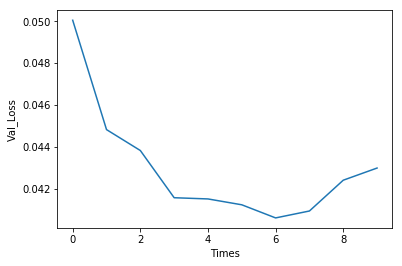

In [63]:
val_loss = hist.history['val_loss']
plt.plot(val_loss)
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.show()